<a href="https://colab.research.google.com/github/benai9916/Deep-Learning/blob/master/Digit_recognizer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Library

In [95]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import  plot_model

# Load and data analysis
This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
TO know more about dataset please check here  https://keras.io/api/datasets/mnist/

In [96]:
dataset = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = dataset.load_data()

In [97]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(set(pd.unique(y_train)))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Observations:

- There are 60,000 images. We assigned 10,000 to test dataset
- Images are black and white and is of 28 x 28 pixels
- Train Images: Array of 60,000 images in 28 X 28 pixel
- Train Labels: Integer array of 60,000 labels, value between 0 to 9
- Test Images: Array of 10,000 images in 28 X 28 pixel
- Test Labels: Integer array of 10,000 labels, value between 0 to 9
- Each image mapped to a single label
- Each integer value in label array represent digits

# Evaluation of the data

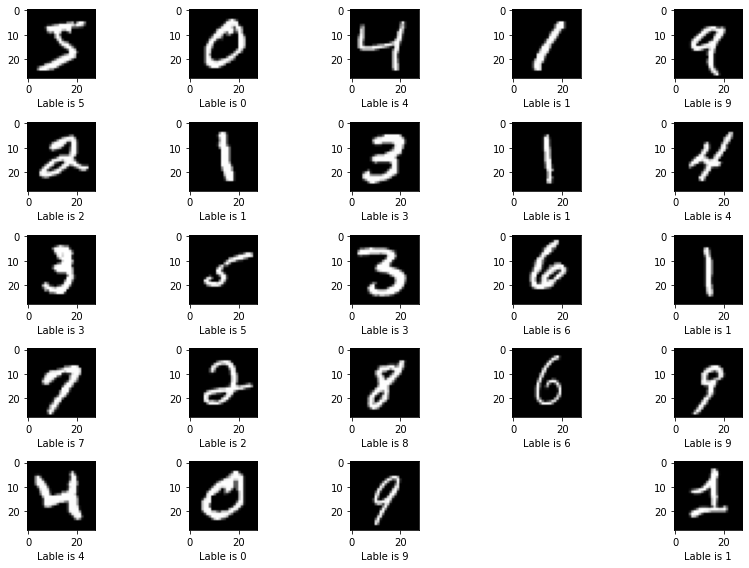

In [98]:
plt.figure(figsize=(12,8))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(x_train[i], cmap='gray')
  plt.tight_layout()
  plt.xlabel('Lable is {}'.format(y_train[i]))

# Data Preparation

In [99]:
x_train = x_train/255.0
x_train = x_train[..., tf.newaxis]  # adding a channel dimension

x_test = x_test/255.0
x_test = x_test[..., tf.newaxis]

# Batching and shuffling, prefetching
Now the data is preprocessed there are few configurations that can be made to the pipeline. Here's a list of those configurations:

- **Shuffle**: To make sure the model doesn't pick up anything from the order of the rows in the dataset the top 100 rows of data will be shuffled per training step.
- **Batch**: This is quite a large dataset in terms of both rows and columns. To ensure the processor doesn't get overloaded the data will be fed in 32 images at a time.
- **Prefetch**: The speed up the training the pipeline can be set to fetch the next batch of data while the current batch of data is in training. When the current step ends there is no time wasted loading the next batch as it is ready to go.

In [100]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).shuffle(500).prefetch(tf.data.experimental.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).shuffle(500).prefetch(tf.data.experimental.AUTOTUNE)

# Modelling - Model on CNN

The data is now ready to be fed into a model. I've chosen to use a CNN here and will be using an architecture based on the LeNet-5 architecture.

All average pooling layers have been replaced with max pooling layers
The input shape is slightly smaller than the 32x32 shape in the paper. The first convolutional layer uses "same" padding to ensure the data is in the same shape as it is in the paper by the time it hits the first pooling layer.

In [101]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(6, (5, 5), padding='same', activation='relu', input_shape=(28,28,1)),
  tf.keras.layers.MaxPool2D((2,2)),
  
  tf.keras.layers.Conv2D(16, (5, 5), padding='valid', activation='relu'),
  tf.keras.layers.MaxPool2D((2,2)),

  # Flatten

 tf.keras.layers.Flatten(),

 tf.keras.layers.Dense(units=120, activation='relu'),

 tf.keras.layers.Dense(84, activation='relu'),

 tf.keras.layers.Dense(10, activation='softmax')
])

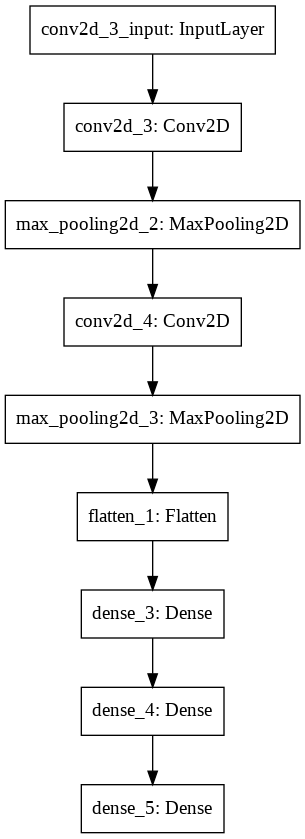

In [102]:
plot_model(model)

# Compile the mode

In [103]:
# if we use softmax activation in output layer then best fit optimizer is categorical_crossentropy
# for sigmoid activation in output layer then loss will be binary_crossentropy

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

Tensorflow has a piece of functionality called callbacks that enable us to monitor the models metrcis during training and take some action as a result. Using this functionality I will implement the following:

- **Learning Rate Decay:** If the models loss does not reduce for 2 consecutive epochs, reduce the learning rate. This should stop the model stepping over the optimum too many times.
- **Early Stopping:** If the models loss does not reduce for 5 consecutive epochs then it's clear the model is not learning anything anymore. Save some computation and stop training.

In [104]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

# Train the model

In [135]:
model = model.fit(train_data, epochs=30, validation_data=test_data, callbacks=callbacks)

Epoch 1/30
1875/1875 [==============================] - 29s 15ms/step - loss: 6.6704e-06 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9919
Epoch 2/30
1875/1875 [==============================] - 28s 15ms/step - loss: 6.6510e-06 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9919
Epoch 3/30
1875/1875 [==============================] - ETA: 0s - loss: 6.6313e-06 - accuracy: 1.0000
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
1875/1875 [==============================] - 28s 15ms/step - loss: 6.6313e-06 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9919
Epoch 4/30
1875/1875 [==============================] - 30s 16ms/step - loss: 6.6145e-06 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9919
Epoch 5/30
1874/1875 [============================>.] - ETA: 0s - loss: 6.6170e-06 - accuracy: 1.0000
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
1875/1875 [==============================] - 28

# Evaluation of the model

In [122]:
# # evaluate accuracy of the model

test_loss, test_acc = model.evaluate(test_data)
print("accuracy:", test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.0497 - accuracy: 0.9919
accuracy: 0.9919000267982483


Training accuracy: 1.000000
Validation accuracy: 0.991900


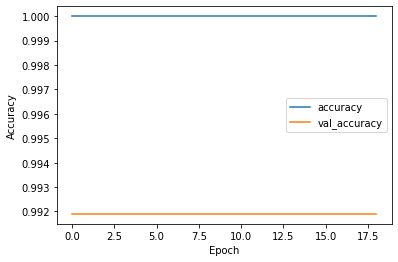

In [136]:
# plot the accuracy

plt.plot(model.history['accuracy'], label='accuracy')
plt.plot(model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print('Training accuracy: %f' % model.history['accuracy'][-1])
print('Validation accuracy: %f' % model.history['val_accuracy'][-1])